# 1. 포켓몬 149종 분류
  * Train: https://www.kaggle.com/datasets/thedagger/pokemon-generation-one
  * Validation: https://www.kaggle.com/hlrhegemony/pokemon-image-dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import os

In [4]:
os.environ['KAGGLE_USERNAME'] = 'wooseok1004'   # username
os.environ['KAGGLE_KEY']  = '712fb964562ed4406107ee277db64263'  # key

In [5]:
!kaggle datasets download -d thedagger/pokemon-generation-one
!unzip -q pokemon-generation-one.zip

pokemon-generation-one.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!kaggle datasets download -d hlrhegemony/pokemon-image-dataset
!unzip -q pokemon-image-dataset.zip

pokemon-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# 디렉토리 이름 변경
!mv dataset train

In [8]:
!mv images validation

In [9]:
# 중복된 dataset 디렉토리 삭제
!rm -rf train/dataset

In [10]:
import os

In [11]:
train_labels = os.listdir('train')
len(train_labels)

149

In [12]:
val_labels = os.listdir('validation')
len(val_labels)

150

In [13]:
import shutil

In [14]:
for val_label in val_labels:
    if val_label not in train_labels:
        shutil.rmtree(os.path.join('validation', val_label))

val_labels = os.listdir('validation')
len(val_labels)

149

In [15]:
for train_label in train_labels:
    if train_label not in val_labels:
        print(train_label)
        os.makedirs(os.path.join('validation', train_label), exist_ok = True)

val_labels = os.listdir('validation')
print(len(val_labels))

149


In [16]:
# 'validation' 폴더에 파오리(Farfetchd), 마임맨(MrMime) 이미지 추가해야함 (이미지명 : 0.jpg)

data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),     # 함수를 10가지 랜덤하게 생성
        transforms.RandomHorizontalFlip(),  # 이미지를 뒤집기
        transforms.ToTensor()
    ]),
    'validation' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

image_datasets = {
    'train': datasets.ImageFolder('train', data_transforms['train']),
    'validation': datasets.ImageFolder('validation', data_transforms['validation'])
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

10657 661


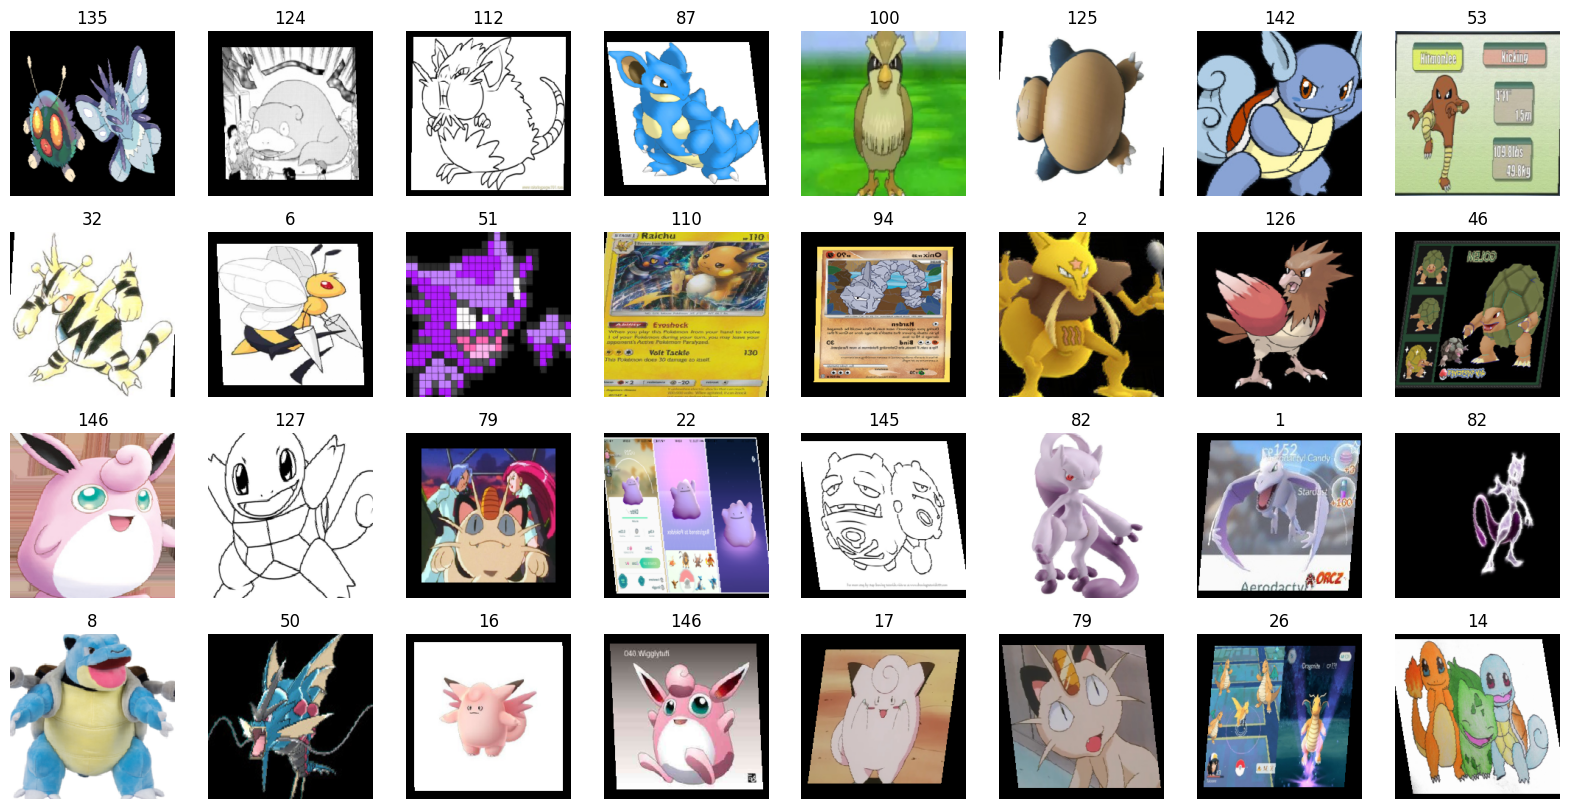

In [17]:
imgs, lavels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, lavels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

In [18]:
# 클래스 이름 확인하기
print(image_datasets['train'].classes)
print(image_datasets['train'].classes[0])

['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Nidoqueen', 'Nidorina'

In [19]:
# 사전 학습된 모델 중 EfficientNet B4 모델 사용하기
model = models.efficientnet_b4(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 90.2MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [20]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1792, 512),
    nn.ReLU(),
    nn.Linear(512, 149)
).to(device)

print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [21]:
# 학습
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.CrossEntropyLoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_prob = nn.Softmax(1)(y_pred)
            y_pred_index = torch.argmax(y_prob, axis=1)
            acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100

            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss:{avg_loss:.4f}, Accuracy:{avg_acc:.2f}%')

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train     : Epoch    1/10, Loss:3.3444, Accuracy:30.07%
validation: Epoch    1/10, Loss:1.4260, Accuracy:68.80%
train     : Epoch    2/10, Loss:1.8133, Accuracy:57.72%
validation: Epoch    2/10, Loss:0.9731, Accuracy:75.66%
train     : Epoch    3/10, Loss:1.5001, Accuracy:63.37%
validation: Epoch    3/10, Loss:0.8096, Accuracy:79.97%
train     : Epoch    4/10, Loss:1.3015, Accuracy:67.53%
validation: Epoch    4/10, Loss:0.6727, Accuracy:81.75%
train     : Epoch    5/10, Loss:1.2316, Accuracy:69.70%
validation: Epoch    5/10, Loss:0.5966, Accuracy:85.18%
train     : Epoch    6/10, Loss:1.0884, Accuracy:72.35%
validation: Epoch    6/10, Loss:0.5819, Accuracy:84.51%
train     : Epoch    7/10, Loss:1.0157, Accuracy:73.59%
validation: Epoch    7/10, Loss:0.5399, Accuracy:85.63%
train     : Epoch    8/10, Loss:0.9191, Accuracy:75.31%
validation: Epoch    8/10, Loss:0.5717, Accuracy:85.18%
train     : Epoch    9/10, Loss:0.8809, Accuracy:76.42%
validation: Epoch    9/10, Loss:0.5481, Accuracy

In [22]:
torch.save(model.state_dict(), 'model.h5')

In [23]:
model = models.efficientnet_b4().to(device)

model.classifier = nn.Sequential(
    nn.Linear(1792, 512),
    nn.ReLU(),
    nn.Linear(512, 149)
).to(device)

model.load_state_dict(torch.load('model.h5'))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

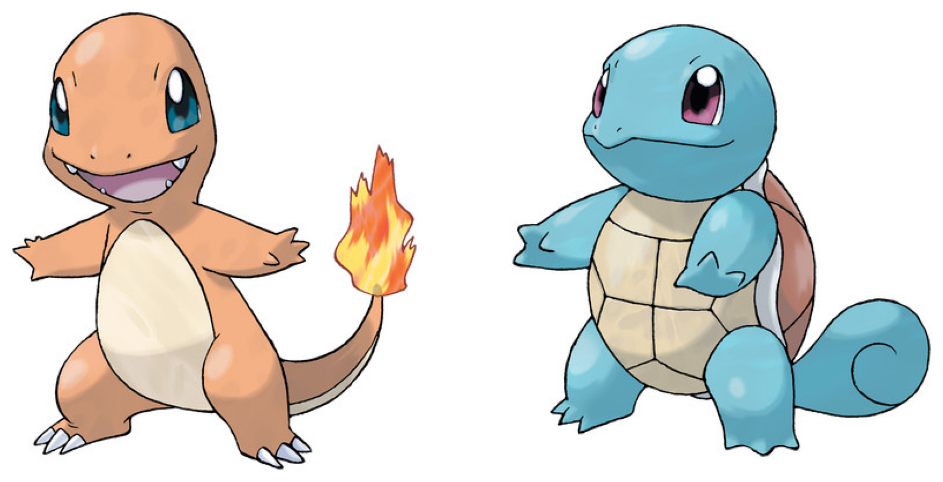

In [24]:
# 테스트
from PIL import Image

img1 = Image.open('validation/Charmander/0.jpg')
img2 = Image.open('validation/Squirtle/0.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [25]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [26]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [27]:
y_pred = model(test_batch)
y_pred

tensor([[-10.7851, -20.0830, -12.7530, -12.4568,  -8.1833, -13.3432, -18.0743,
          -9.0228, -11.2050, -10.0785, -19.6681, -20.1802, -14.1761,  -7.8045,
           6.6283,  -2.4848, -20.5656, -17.3696, -22.6147,  -5.0415,  -3.7978,
          -2.8814, -20.1477, -14.2401, -12.9946, -10.1601,  -6.0329, -12.2059,
         -10.8314,  -4.0517, -11.0365, -12.4147, -14.4622, -13.6158, -17.0470,
         -14.2465, -10.1343, -11.8760, -13.3392, -15.4211, -14.0645,  -9.7603,
         -12.6657, -19.0904,  -9.9370,  -1.7206,  -8.8372, -11.9501, -15.2051,
          -7.7516, -20.1466, -15.4388,  -3.2710,  -5.9573,  -9.5084, -11.9305,
         -17.8595, -17.0504, -13.9990, -13.9695,  -2.4441, -11.3421, -13.2705,
         -14.5681,  -3.5410, -12.5152, -22.5085,  -9.6691,  -7.5654, -12.9243,
         -13.2249, -11.5148,  -3.5365, -12.6468,  -7.7186, -10.9037, -17.5829,
          -4.8116,  -6.2201, -11.7645, -16.3227,  -7.4135, -10.3653, -17.9609,
         -19.0187, -15.6505, -16.4121, -13.7986,  -9

In [28]:
y_pred = model(test_batch)
y_pred

tensor([[-10.7851, -20.0830, -12.7530, -12.4568,  -8.1833, -13.3432, -18.0743,
          -9.0228, -11.2050, -10.0785, -19.6681, -20.1802, -14.1761,  -7.8045,
           6.6283,  -2.4848, -20.5656, -17.3696, -22.6147,  -5.0415,  -3.7978,
          -2.8814, -20.1477, -14.2401, -12.9946, -10.1601,  -6.0329, -12.2059,
         -10.8314,  -4.0517, -11.0365, -12.4147, -14.4622, -13.6158, -17.0470,
         -14.2465, -10.1343, -11.8760, -13.3392, -15.4211, -14.0645,  -9.7603,
         -12.6657, -19.0904,  -9.9370,  -1.7206,  -8.8372, -11.9501, -15.2051,
          -7.7516, -20.1466, -15.4388,  -3.2710,  -5.9573,  -9.5084, -11.9305,
         -17.8595, -17.0504, -13.9990, -13.9695,  -2.4441, -11.3421, -13.2705,
         -14.5681,  -3.5410, -12.5152, -22.5085,  -9.6691,  -7.5654, -12.9243,
         -13.2249, -11.5148,  -3.5365, -12.6468,  -7.7186, -10.9037, -17.5829,
          -4.8116,  -6.2201, -11.7645, -16.3227,  -7.4135, -10.3653, -17.9609,
         -19.0187, -15.6505, -16.4121, -13.7986,  -9

In [29]:
y_prob = nn.Softmax(1)(y_pred)
y_prob

tensor([[2.7306e-08, 2.5018e-12, 3.8162e-09, 5.1315e-09, 3.6831e-07, 2.1150e-09,
         1.8647e-11, 1.5908e-07, 1.7943e-08, 5.5352e-08, 3.7881e-12, 2.2701e-12,
         9.1958e-10, 5.3795e-07, 9.9729e-01, 1.0992e-04, 1.5441e-12, 3.7728e-11,
         1.9896e-13, 8.5252e-06, 2.9569e-05, 7.3925e-05, 2.3451e-12, 8.6259e-10,
         2.9971e-09, 5.1014e-08, 3.1633e-06, 6.5952e-09, 2.6073e-08, 2.2937e-05,
         2.1237e-08, 5.3523e-09, 6.9073e-10, 1.6104e-09, 5.2090e-11, 8.5705e-10,
         5.2351e-08, 9.1732e-09, 2.1235e-09, 2.6478e-10, 1.0281e-09, 7.6091e-08,
         4.1644e-09, 6.7501e-12, 6.3769e-08, 2.3601e-04, 1.9152e-07, 8.5179e-09,
         3.2861e-10, 5.6719e-07, 2.3476e-12, 2.6014e-10, 5.0072e-05, 3.4117e-06,
         9.7890e-08, 8.6864e-09, 2.3115e-11, 5.1912e-11, 1.0977e-09, 1.1306e-09,
         1.1448e-04, 1.5645e-08, 2.2744e-09, 6.2136e-10, 3.8224e-05, 4.8405e-09,
         2.2124e-13, 8.3355e-08, 6.8321e-07, 3.2154e-09, 2.3805e-09, 1.3164e-08,
         3.8399e-05, 4.2438e

In [30]:
probs, indices = torch.topk(y_prob, k=3, axis=-1)       # k = 3 : 3등까지 불러오기 / axis = 1 or -1 무관

probs = probs.cpu().data.numpy()        # 확률
indices = indices.cpu().data.numpy()    # 인덱스

print(probs)
print(indices)

[[9.9728501e-01 1.9408371e-03 2.3600746e-04]
 [9.9997687e-01 9.9281724e-06 8.6717937e-06]]
[[ 14 127  45]
 [127  14 142]]


In [31]:
9.9966812e-01

0.99966812

In [32]:
9.9713159e-01

0.99713159

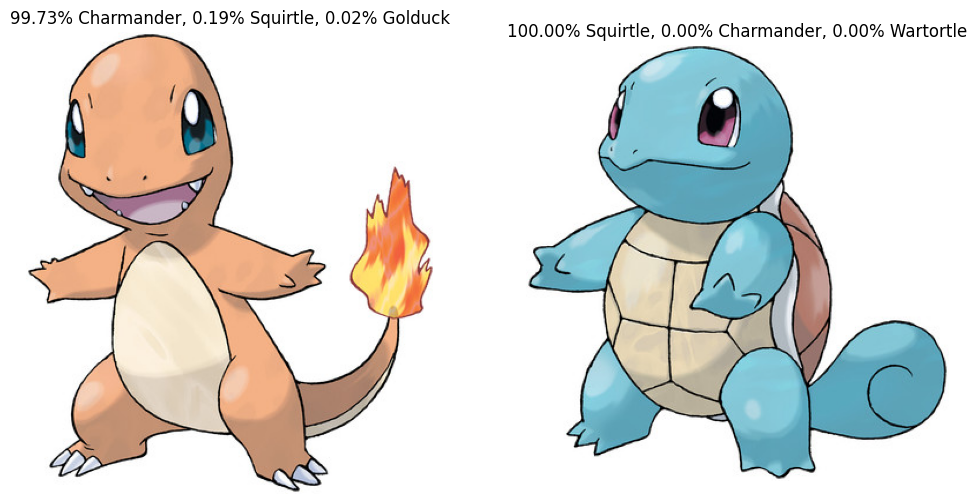

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('{:.2f}% {}, {:.2f}% {}, {:.2f}% {}'.format(
    probs[0, 0] * 100, image_datasets['validation'].classes[indices[0, 0]],
    probs[0, 1] * 100, image_datasets['validation'].classes[indices[0, 1]],
    probs[0, 2] * 100, image_datasets['validation'].classes[indices[0, 2]]
))
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title('{:.2f}% {}, {:.2f}% {}, {:.2f}% {}'.format(
    probs[1, 0] * 100, image_datasets['validation'].classes[indices[1, 0]],
    probs[1, 1] * 100, image_datasets['validation'].classes[indices[1, 1]],
    probs[1, 2] * 100, image_datasets['validation'].classes[indices[1, 2]]
))
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()